In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from tensorflow.keras import layers, models, callbacks
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 0) Reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# 1) Config
SYMBOL      = 'NVDA'
START_DATE  = '2022-01-01'
END_DATE    = '2024-12-31'
SEQ_LEN     = 60
TEST_SIZE   = 0.2
MAX_EPOCHS  = 50
BATCH_SIZE  = 32
FUTURE_DAYS = 30

In [ ]:
# 1.1) Load FinBERT for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_f = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        out = model_f(**inputs)
        probs = softmax(out.logits, dim=-1)[0]
    return probs[0].item(), probs[1].item(), probs[2].item()

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# 1.2) Load and process news data
news_df = pd.read_csv('nvidia_news.csv', parse_dates=['Date'])

In [ ]:

news_df.head()

,Title,Link,Source,Date
0,Nvidia Stock To $60?,https://www.forbes.com/sites/greatspeculations...,Forbes,2022-01-03
1,"Markets News, Mar. 1, 2024: Nasdaq Climbs to A...",https://www.investopedia.com/dow-jones-today-0...,Investopedia,2022-01-04
2,"NVIDIA Launches Salvo Of Gaming GPUs, New Omni...",https://www.forbes.com/sites/davealtavilla/202...,Forbes,2022-01-05
3,Early NVIDIA GeForce RTX 3080 12 GB benchmarks...,https://www.notebookcheck.net/Early-NVIDIA-GeF...,Notebookcheck,2022-01-06
4,AMD Radeon RX 6300M and RX 6500M to feature Na...,https://www.notebookcheck.net/AMD-Radeon-RX-63...,Notebookcheck,2022-01-07


In [ ]:

news_scores = []
for _, row in news_df.iterrows():
    pos, neg, neu = get_sentiment(str(row['Title']))
    news_scores.append({'Date': row['Date'], 'positive': pos, 'negative': neg, 'neutral': neu})

news_s = pd.DataFrame(news_scores)

In [ ]:
news_s.head()

,Date,positive,negative,neutral
0,2022-01-03,0.116059,0.028572,0.855369
1,2022-01-04,0.916383,0.030425,0.053191
2,2022-01-05,0.128847,0.010969,0.860184
3,2022-01-06,0.332687,0.015826,0.651487
4,2022-01-07,0.819219,0.011189,0.169592


In [ ]:
# 2) Load stock data
df = pd.read_csv('stock_data.csv', parse_dates=['Date'])

In [ ]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2022-01-03,30.068224,30.657190,29.732812,29.762760,391547000
1,2022-01-04,29.238680,30.414615,28.299329,30.223950,527154000
2,2022-01-05,27.555634,29.364459,27.484759,28.898276,498064000
3,2022-01-06,28.128626,28.388171,27.017577,27.591568,454186000
4,2022-01-07,27.199257,28.372199,27.009589,28.091691,409939000


In [ ]:
# 3) Feature engineering
# Ensure sorted by date
df.sort_values('Date', inplace=True)
# Moving averages
df['MA10'] = df['Close'].rolling(10).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
# RSI calculation
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
avg_gain = up.rolling(14).mean()
avg_loss = down.rolling(14).mean()
df['RSI'] = 100 - 100/(1 + avg_gain/avg_loss)
# Returns
df['Return'] = df['Close'].pct_change()
# MACD
exp1 = df['Close'].ewm(span=12).mean()
exp2 = df['Close'].ewm(span=26).mean()
df['MACD'] = exp1 - exp2

In [ ]:
# 4) Merge stock with sentiment
merged = pd.merge(df, news_s, on='Date', how='left')
# Fill missing sentiment by forward/back fill
merged[['positive','negative','neutral']] = merged[['positive','negative','neutral']].fillna(method='ffill').bfill()
merged.set_index('Date', inplace=True)
merged.dropna(inplace=True)

In [ ]:
merged.head()

,Close,High,Low,Open,Volume,MA10,EMA20,RSI,Return,MACD,positive,negative,neutral
Date,,,,,,,,,,,,,
2022-01-24,23.331049,23.339034,20.851402,22.290875,913982000,25.814588,25.901225,16.704460,-0.000085,-0.658324,0.290104,0.011724,0.698173
2022-01-25,22.284883,22.902800,21.961452,22.506495,664616000,25.307878,25.469831,16.354296,-0.044840,-0.779658,0.040851,0.023235,0.935915
2022-01-26,22.732098,24.014846,22.260925,23.199278,755959000,24.804262,25.150917,23.491295,0.020068,-0.834841,0.112877,0.016108,0.871016
2022-01-27,21.905550,23.952957,21.637020,23.526705,573353000,24.199823,24.780736,16.727134,-0.036360,-0.918967,0.022180,0.043012,0.934808
2022-01-28,22.799978,22.817946,21.258683,21.973428,543774000,23.826977,24.558976,26.390201,0.040831,-0.915065,0.367886,0.010431,0.621682


In [ ]:
# 5) Prepare features and scale
features = ['Open','High','Low','Close','Volume','MA10','EMA20','RSI','Return','MACD',
            'positive','negative','neutral']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(merged[features])

In [ ]:
# 6) Build sequences
X, y = [], []
for i in range(len(scaled) - SEQ_LEN):
    X.append(scaled[i:i+SEQ_LEN])
    y.append(scaled[i+SEQ_LEN, features.index('Close')])
X, y = np.array(X), np.array(y)

# 7) Train/Test split
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
# 8) Attention layer definition
class Attention(layers.Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1],1), initializer='glorot_uniform', trainable=True)
    def call(self, x):
        e = tf.matmul(tf.tanh(x), self.W)      # (batch, time, 1)
        a = tf.nn.softmax(e, axis=1)           # normalize over time
        return tf.reduce_sum(x * a, axis=1) # This should return a tensor

In [ ]:
# 9) Model builder for Keras Tuner
def build_model(hp):
    inp = layers.Input(shape=(SEQ_LEN, len(features)))
    x = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units', 64, 256, step=64),
        return_sequences=True,
        dropout=hp.Float('dropout_lstm', 0.0, 0.5, step=0.1)
    ))(inp)
    x = Attention()(x) # The output of Attention should be passed here
    x = layers.Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_dense', 0.0, 0.5, step=0.1))(x)
    out = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae', 'mape']
    )
    return model

In [ ]:
# 10) Hyperparameter tuning with Hyperband
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=MAX_EPOCHS,
    factor=3,
    directory='tuner_dir',
    project_name='nvda_refined'
)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[stop_early],
    verbose=1
)

Trial 90 Complete [00h 02m 44s]
val_loss: 0.007351210340857506

Best val_loss So Far: 0.001408228650689125
Total elapsed time: 01h 14m 05s


In [ ]:

# 11) Retrieve best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters:", tuner.get_best_hyperparameters()[0].values)

Best hyperparameters: {'lstm_units': 128, 'dropout_lstm': 0.1, 'dense_units': 64, 'dropout_dense': 0.1, 'learning_rate': 0.009480521002476422, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0076'}


In [ ]:
# 12) Fine-tune best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ],
    verbose=1
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0147 - mae: 0.0832 - mape: 665.1423

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0144 - mae: 0.0822 - mape: 803.0692 - val_loss: 0.0132 - val_mae: 0.1068 - val_mape: 12.3196 - learning_rate: 0.0095
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0024 - mae: 0.0355 - mape: 19481.4277 - val_loss: 0.0140 - val_mae: 0.1114 - val_mape: 12.9048 - learning_rate: 0.0095
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.0019 - mae: 0.0305 - mape: 13539.7959 - val_loss: 0.0166 - val_mae: 0.1230 - val_mape: 14.3364 - learning_rate: 0.0095
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0030 - mae: 0.0373 - mape: 10295.7217

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0030 - mae: 0.0370 - mape: 12763.2412 - val_loss: 0.0073 - val_mae: 0.0790 - val_mape: 9.1817 - learning_rate: 0.0095
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0011 - mae: 0.0236 - mape: 8431.2480

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.0012 - mae: 0.0236 - mape: 10453.4365 - val_loss: 0.0036 - val_mae: 0.0536 - val_mape: 6.2357 - learning_rate: 0.0095
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 0.0019 - mae: 0.0294 - mape: 14289.8545 - val_loss: 0.0088 - val_mae: 0.0877 - val_mape: 10.2430 - learning_rate: 0.0095
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0015 - mae: 0.0265 - mape: 9909.2119

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.0015 - mae: 0.0265 - mape: 12285.0342 - val_loss: 0.0012 - val_mae: 0.0274 - val_mape: 3.3574 - learning_rate: 0.0095
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0018 - mae: 0.0275 - mape: 15771.8818 - val_loss: 0.0065 - val_mae: 0.0746 - val_mape: 8.7486 - learning_rate: 0.0095
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0018 - mae: 0.0279 - mape: 21443.7754 - val_loss: 0.0088 - val_mae: 0.0884 - val_mape: 10.3881 - learning_rate: 0.0095
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0016 - mae: 0.0264 - mape: 14158.3232 - val_loss: 0.0013 - val_mae: 0.0283 - val_mape: 3.4247 - learning_rate: 0.0095
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.0012 - mae: 0.0238 - mape: 11950.6777 - val_loss: 0.0056 - val_mae: 0.0690 - val_mape: 8.0805 - learning_rate: 0.0095
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 0.0023 - mae: 0.0288 - mape: 10671.7773 - val_l

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.0017 - mae: 0.0273 - mape: 24466.3379 - val_loss: 0.0012 - val_mae: 0.0268 - val_mape: 3.2748 - learning_rate: 0.0047
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0012 - mae: 0.0236 - mape: 23927.8984 - val_loss: 0.0066 - val_mae: 0.0755 - val_mape: 8.8094 - learning_rate: 0.0047
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0020 - mae: 0.0297 - mape: 10248.3496 - val_loss: 0.0013 - val_mae: 0.0289 - val_mape: 3.4603 - learning_rate: 0.0047
Epoch 16/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.0014 - mae: 0.0232 - mape: 11274.5029 - val_loss: 0.0024 - val_mae: 0.0423 - val_mape: 4.9624 - learning_rate: 0.0047
Epoch 17/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.0011 - mae: 0.0232 - mape: 11846.2471 - val_loss: 0.0012 - val_mae: 0.0277 - val_mape: 3.4082 - learning_rate: 0.0047
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0015 - mae: 0.0257 - mape: 7091.6465

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.0014 - mae: 0.0255 - mape: 8790.7539 - val_loss: 0.0010 - val_mae: 0.0255 - val_mape: 3.1047 - learning_rate: 0.0024
Epoch 19/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.0013 - mae: 0.0227 - mape: 8645.2129 - val_loss: 0.0029 - val_mae: 0.0478 - val_mape: 5.5909 - learning_rate: 0.0024
Epoch 20/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0011 - mae: 0.0218 - mape: 3524.9675

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0011 - mae: 0.0218 - mape: 4367.3892 - val_loss: 9.9407e-04 - val_mae: 0.0249 - val_mape: 3.0391 - learning_rate: 0.0024


In [ ]:
# 13) Evaluate on test set
y_pred = best_model.predict(X_test)

# Invert scaling for predictions & true values
dummy = np.zeros((len(y_pred), len(features)))
dummy[:, features.index('Close')] = y_pred.flatten()
pred_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]
dummy[:, features.index('Close')] = y_test
true_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
mape = np.mean(np.abs((true_prices - pred_prices) / true_prices)) * 100
r2 = r2_score(true_prices, pred_prices)

print(f"\nResults (LSTM+Attention+Sentiment Removed Compound):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R\u00b2  : {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step

Results (LSTM+Attention+Sentiment Removed Compound):
RMSE: 4.34
MAE : 3.43
MAPE: 2.76%
R²  : 0.8736


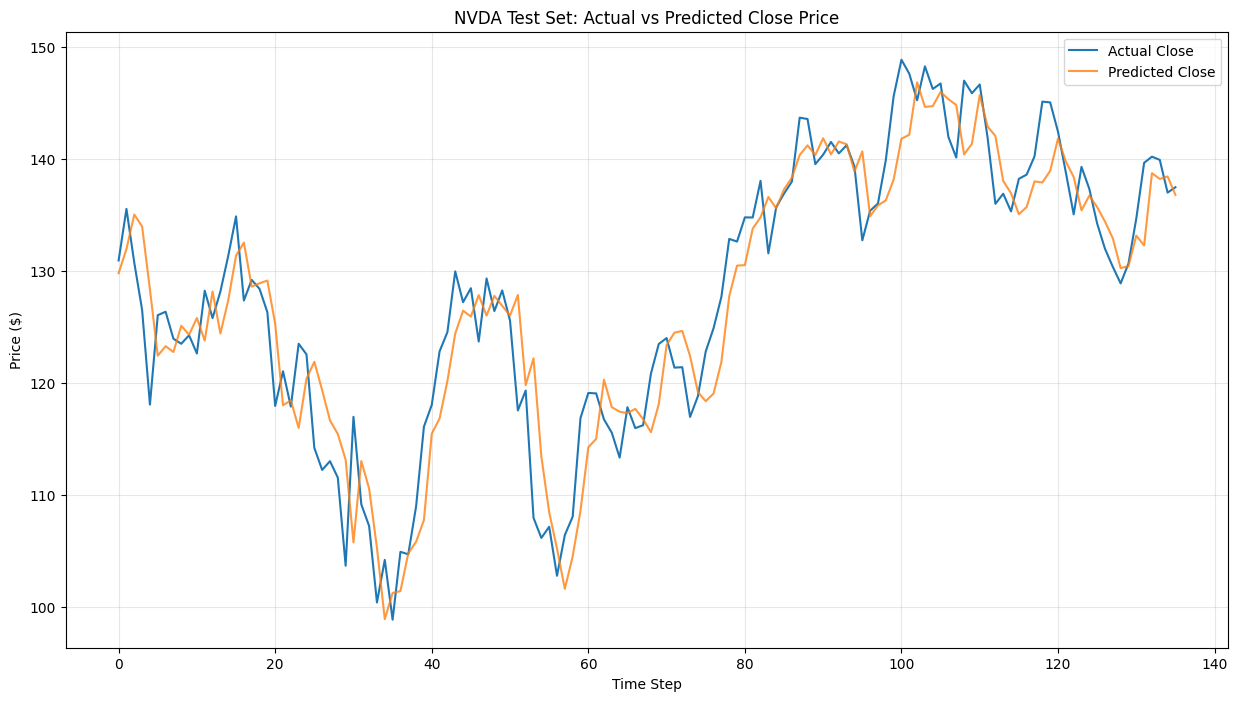

In [ ]:


# 14) Plot actual vs predicted
plt.figure(figsize=(15, 8))
plt.plot(true_prices, label='Actual Close')
plt.plot(pred_prices, label='Predicted Close', alpha=0.8)
plt.title(f'{SYMBOL} Test Set: Actual vs Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()